In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import Bio
import Bio.SeqIO
import re
import os
import pickle

from timeit import default_timer as timer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from timeit import default_timer as timer


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
DEVICE

device(type='cuda')

In [6]:
os.sys.path.append('/home/yisupeng/workspace/CAFA_CODE/python/')

In [7]:
from ontology import *

In [8]:
from gene_ontology import *

## Dataset

### Target vocab

In [9]:
ont_pickle = 'states/ont.pickle'
if os.path.exists(ont_pickle):
    ont = pickle.load(open(ont_pickle, 'rb'))
else:
    ont = Ontology(parse_ont('data/go-basic.obo'))
    pickle.dump(ont, open(ont_pickle, 'wb'))

In [10]:
ont.roots

{'GO:0003674', 'GO:0005575', 'GO:0008150'}

In [11]:
class OntVocab:
    def __init__(self, ont):
        self.terms = []
        term_ind = {}
        for i, k in enumerate(ont.topological_order()):
            v = ont[k]
            if v.depth > 3:
                break
            term_ind[k] = i
            self.terms.append(k)
        self.term_ind = term_ind

    def __getitem__(self, i):
        return self.terms[i]

    def __call__(self, token):
        return self.term_ind[token]


target_vocab = OntVocab(ont)
list(target_vocab)

['GO:0008150',
 'GO:0003674',
 'GO:0005575',
 'GO:0000003',
 'GO:0016032',
 'GO:0042592',
 'GO:0040007',
 'GO:0032502',
 'GO:0044419',
 'GO:0002376',
 'GO:0008152',
 'GO:0044848',
 'GO:0040011',
 'GO:0050896',
 'GO:0065007',
 'GO:0009987',
 'GO:0051179',
 'GO:0043473',
 'GO:0048511',
 'GO:0051703',
 'GO:0032501',
 'GO:0090729',
 'GO:0140104',
 'GO:0140489',
 'GO:0060090',
 'GO:0140223',
 'GO:0003774',
 'GO:0140522',
 'GO:0003824',
 'GO:0140777',
 'GO:0045735',
 'GO:0140299',
 'GO:0060089',
 'GO:0005488',
 'GO:0045182',
 'GO:0038024',
 'GO:0098772',
 'GO:0140912',
 'GO:0044183',
 'GO:0005215',
 'GO:0016209',
 'GO:0140110',
 'GO:0140313',
 'GO:0140657',
 'GO:0140691',
 'GO:0140776',
 'GO:0140911',
 'GO:0005198',
 'GO:0031386',
 'GO:0110165',
 'GO:0044423',
 'GO:0032991',
 'GO:0075325',
 'GO:1990277',
 'GO:0022414',
 'GO:0019954',
 'GO:0019953',
 'GO:0032505',
 'GO:0019080',
 'GO:0046745',
 'GO:0099009',
 'GO:0019058',
 'GO:0046794',
 'GO:0019061',
 'GO:0019042',
 'GO:0098678',
 'GO:00986

In [12]:
len(list(target_vocab))

554

### Source vocab

In [13]:
hyper_aa_regex = re.compile('[BXZJUO]')

In [14]:
MAX_LEN = 2000

In [15]:
import torch

In [16]:
modelname = 'seq_ann_depth3_protbert_llm2vec'

In [17]:
states_dir = f'states/{modelname}/'
if not os.path.exists(states_dir):
    os.makedirs(states_dir)

In [18]:
seq_file = "data/uniprot_sprot.fasta"
# seq_file = "data/debugging_sequence.fasta"

def load_seqdb():
    seqdb_pickle = f'{states_dir}/seqdb.pickle'
    if os.path.exists(seqdb_pickle):
        seqdb = pickle.load(open(seqdb_pickle, 'rb'))
    else:
        seqdb = {}
        irregs = 0
        for record in Bio.SeqIO.parse(seq_file, "fasta"):
            if '|' in record.id:
                _, acc, geneid = record.id.split('|')
            else:
                acc = record.id
            if hyper_aa_regex.findall(str(record.seq)):
                irregs += 1
                continue
            # if len(record.seq) > MAX_LEN:
            #     irregs += 1
            #     continue
            seqdb[acc] = record
        print('irregs', irregs)
        pickle.dump(seqdb, open(seqdb_pickle, 'wb'))
        seqdb = pickle.load(open(seqdb_pickle, 'rb'))
    return seqdb


### build dataset

In [19]:
# load data
# datatab = pd.read_csv('data/sample_annot.csv')
datatab = pd.read_csv('data/linear_annot.csv')
datatab

,UniProt ID,Annotations,Aspect
0,A0A009IHW8,GO:0006807;GO:0044238;GO:0009056;GO:0071704;GO...,BPO
1,A0A021WW32,GO:0065007;GO:0032502;GO:0009987;GO:0008150,BPO
2,A0A023FFD0,GO:0008150,BPO
3,A0A023GPJ3,GO:0008150,BPO
4,A0A023GPK8,GO:0065007;GO:0032502;GO:0008150,BPO
...,...,...,...
242391,X5KCU9,GO:0003824,MFO
242392,X5KJC0,GO:0003824,MFO
242393,X5L1L5,GO:0003824,MFO
242394,X5L565,GO:0003824,MFO


In [20]:
def normalize_ann(ann):
    anns = ann.split(';')
    return list(sorted(anns, key=target_vocab))

In [21]:
normalize_ann('GO:0050896;GO:0009987;GO:0008150')

['GO:0008150', 'GO:0050896', 'GO:0009987']

In [22]:
def build_dataset(datatab, seqdb):
    res = []
    for i, row in datatab.iterrows():
        pid = row['UniProt ID']
        if pid not in seqdb:
            continue
        ann = normalize_ann(row['Annotations'])
        if len(ann) < 3:
            continue
        res.append({'seq': ' '.join(seqdb[pid]), 'ann': ' '.join(ann)})
        # break
    res = pd.DataFrame(res)
    return res


In [23]:
ann_dataset_pickle = 'states/ann_dataset.pickle'

if os.path.exists(ann_dataset_pickle):
    ann_dataset = pickle.load(open(ann_dataset_pickle, 'rb'))
else:
    seqdb = load_seqdb()
    ann_dataset = build_dataset(datatab, seqdb)
    pickle.dump(ann_dataset, open(ann_dataset_pickle, 'wb'))
ann_dataset

,seq,ann
0,M S L E Q K K G A D I I S K I L Q I Q N S I G ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
1,M R F Q V I V A A A T I T M I T S Y I P G V A ...,GO:0008152 GO:0044238 GO:0009056 GO:0071704
2,M K N P K K K S G G F R I V N M L K R G V A R ...,GO:0008150 GO:0016032 GO:0065007
3,M M K M K Q Q G L V A D L L P N I R V M K T F ...,GO:0008150 GO:0051703 GO:0050896 GO:0032502
4,M A R G T F E R T K K L R E E S I N A E P H I ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
...,...,...
53281,M N S Q N P D D H E D T T V V G F E V P V S P ...,GO:0098772 GO:0005488 GO:0030234
53282,M R V H R F C V I V I F L T E L L C F F Y S S ...,GO:0003824 GO:0060089 GO:0005488 GO:0038023
53283,M R A A I N R A N S L G G L F S F R F I R N I ...,GO:0098772 GO:0005488 GO:0030234
53284,M A K D G G V S C L R R S E M I G I G I G E L ...,GO:0060089 GO:0005488 GO:0000156


In [24]:
ann_dataset = ann_dataset[ann_dataset['seq'].apply(lambda x: len(x.split()) < 500)]

In [25]:
ann_dataset

,seq,ann
0,M S L E Q K K G A D I I S K I L Q I Q N S I G ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
3,M M K M K Q Q G L V A D L L P N I R V M K T F ...,GO:0008150 GO:0051703 GO:0050896 GO:0032502
6,M R S V S G Q V V C V T G A G G F I A S W L V ...,GO:0008150 GO:0048511 GO:0009987 GO:0008152 GO...
8,M A M P Y A S L S P A G A A D H R S S T A T A ...,GO:0008150 GO:0065007 GO:0032502
11,M P M A S V I A V A E P K W I S V W G R F L W ...,GO:0008150 GO:0065007 GO:0008152 GO:0071704 GO...
...,...,...
53278,M D L V Q K Q K S L Q D Y T K S L F L E G I L ...,GO:0003824 GO:0060089 GO:0005488
53280,M A A S M T K P I S I T S L G F Y S D R K N I ...,GO:0098772 GO:0005488 GO:0030234
53281,M N S Q N P D D H E D T T V V G F E V P V S P ...,GO:0098772 GO:0005488 GO:0030234
53283,M R A A I N R A N S L G G L F S F R F I R N I ...,GO:0098772 GO:0005488 GO:0030234


In [26]:
ann_comb_counts = dict(ann_dataset['ann'].value_counts())

In [27]:
# ann_dataset = ann_dataset[ann_dataset['ann'].apply(lambda x: ann_comb_counts[x] < 500)]
# ann_dataset

In [28]:
ann_dataset['ann'].value_counts()

ann
GO:0008150 GO:0050896 GO:0009987                                                                                                                  1374
GO:0005575 GO:0110165 GO:0032991                                                                                                                  1193
GO:0008150 GO:0009987 GO:0008152 GO:0009058 GO:0071704 GO:0006807                                                                                  980
GO:0005575 GO:0032991 GO:1902494                                                                                                                   730
GO:0008150 GO:0009987 GO:0008152 GO:0071704 GO:0006807                                                                                             675
                                                                                                                                                  ... 
GO:0008150 GO:0050896 GO:0065007 GO:0009987 GO:0032501 GO:0044238 GO:0071704 GO:0044281 GO

<Axes: ylabel='Frequency'>

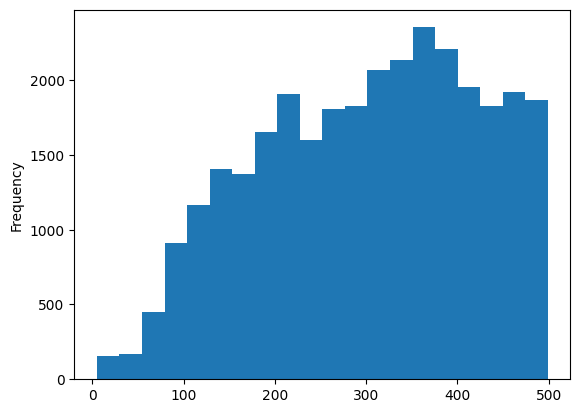

In [29]:
(ann_dataset['seq'].apply(lambda x: len(x.split()) if len(x.split()) < 500 else None)).plot.hist(bins=20)

In [30]:
(ann_dataset['ann'].apply(lambda x: len(x))<5).sum()

0

In [31]:
ann_dataset = ann_dataset.sample(frac=1).reset_index(drop=True)
ann_dataset

,seq,ann
0,M V G S R V Y V G G L P Y G V R E R D L E R F ...,GO:0005575 GO:0032991 GO:0032993
1,M A A S C L V L L A L C L L L P L L L L G G W ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
2,M W S L G G L R L A A G H C L R L Y E R N A S ...,GO:0008150 GO:0050896 GO:0009987
3,M L P K R R R V R A G S P H S A V A S S T P P ...,GO:0008150 GO:0002376 GO:0009987 GO:0032501 GO...
4,M S P C K L L P F C V A L A L T G C S L A P D ...,GO:0008150 GO:0042592 GO:0050896 GO:0009987 GO...
...,...,...
30746,M A G L W R S Y Q A L M A K H P W K V Q I I T ...,GO:0008150 GO:0009987 GO:0008152 GO:0032502 GO...
30747,M A T A R P P W M W V L C A L I T A L L L G V ...,GO:0008150 GO:0065007 GO:0009987 GO:0032502
30748,M S S D L R L T L L E L V R R L N G N A T I E ...,GO:0008150 GO:0016032 GO:0065007
30749,M A L P L R T A R H A S R L A Q T I G R R G Y ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...


In [32]:
from toy_transformer import *

2.2.1+cu118


## Masks

In [33]:
def generate_square_subsequent_mask(sz):
    # mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = (torch.tril(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def generate_square_diagnal_mask(sz):
    mask = (torch.diag(torch.ones(sz, device=DEVICE)))
    # mask = 1 - mask
    # mask = torch.zeros([sz, sz], device=DEVICE)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


In [34]:
generate_square_subsequent_mask(5)

tensor([[0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, 0.]], device='cuda:0')

In [35]:
generate_square_diagnal_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf],
        [-inf, -inf, 0., -inf, -inf],
        [-inf, -inf, -inf, 0., -inf],
        [-inf, -inf, -inf, -inf, 0.]], device='cuda:0')

In [36]:
def create_subsequent_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


def target_mask_fn(tgt):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    return tgt_mask


def target_one_out_mask(tgt):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_diagnal_mask(tgt_seq_len)

    return tgt_mask


In [37]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

## Tokenizer

In [38]:
TGT_LANGUAGE = 'ann'
SRC_LANGUAGE = 'seq'

In [39]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.processors import TemplateProcessing

In [40]:
# all_anns = ann_dataset['ann'].apply(lambda x: x.split()).sum()

In [41]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]

def get_tokenizer(lang):
    tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    
    trainer = trainers.WordLevelTrainer(vocab_size=600, special_tokens=special_tokens, min_frequency=0)
    tokenizer.train_from_iterator(list(ann_dataset[lang])*10, trainer=trainer)
    
    tokenizer.post_processor = TemplateProcessing(
        single=f"[CLS]:0 $A:0 [SEP]:0",
        pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
        special_tokens=[
            ("[CLS]", tokenizer.token_to_id('[CLS]')),
            ("[SEP]", tokenizer.token_to_id('[SEP]')),
        ],
    )
    return tokenizer


In [42]:
tokenizers = {lang: get_tokenizer(lang) for lang in (SRC_LANGUAGE, TGT_LANGUAGE)}

In [43]:
tokenizers['ann'].token_to_id('[CLS]')

2

In [44]:
encoding = tokenizers['ann'].encode(ann_dataset.iloc[0].ann)

pd.DataFrame((encoding.tokens, encoding.ids))

,0,1,2,3,4
0,[CLS],GO:0005575,GO:0032991,GO:0032993,[SEP]
1,2,16,17,28,3


In [45]:
encoding = tokenizers['seq'].encode(ann_dataset.iloc[0].seq)

pd.DataFrame((encoding.tokens, encoding.ids))

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
0,[CLS],M,V,G,S,R,V,Y,V,G,...,D,R,N,N,E,S,M,D,D,[SEP]
1,2,21,9,8,6,12,9,20,9,8,...,15,12,18,18,10,6,21,15,15,3


In [46]:
tokenizers['ann'].get_vocab_size()

119

In [47]:
tokenizers['ann'].get_vocab()

{'GO:0036338': 85,
 'GO:0071704': 7,
 '[SEP]': 3,
 'GO:0140776': 88,
 'GO:0045730': 76,
 'GO:0034518': 77,
 'GO:0140223': 73,
 'GO:0019033': 83,
 'GO:0033186': 95,
 'GO:0048511': 46,
 'GO:0051703': 51,
 'GO:0031992': 94,
 'GO:0036284': 112,
 'GO:0009058': 14,
 'GO:0005575': 16,
 'GO:0046729': 86,
 'GO:0016209': 53,
 'GO:0044419': 55,
 'GO:0005488': 20,
 'GO:0016247': 52,
 'GO:0000003': 21,
 'GO:0060089': 32,
 'GO:0003824': 30,
 'GO:0140489': 102,
 'GO:0008152': 8,
 'GO:0030234': 29,
 'GO:0044183': 78,
 'GO:0030545': 35,
 'GO:1990526': 108,
 'GO:0038024': 71,
 'GO:0002252': 43,
 'GO:1990845': 74,
 'GO:0140313': 66,
 'GO:0032994': 72,
 'GO:0032991': 17,
 'GO:1904090': 90,
 'GO:0044423': 63,
 'GO:0019748': 39,
 'GO:0042440': 45,
 'GO:0000408': 84,
 'GO:0140110': 48,
 'GO:0040007': 34,
 'GO:0016032': 41,
 'GO:0140912': 117,
 'GO:0140657': 47,
 'GO:0008150': 5,
 'GO:0065007': 9,
 'GO:0045182': 61,
 '[UNK]': 0,
 'GO:0040011': 37,
 'GO:0140677': 60,
 'GO:0032963': 82,
 'GO:0030228': 92,
 'GO:

In [48]:
tokenizers['seq'].get_vocab_size()

25

In [49]:
tokenizers['seq'].encode('A D A').ids

[2, 7, 15, 7, 3]

In [50]:
tokenizers['ann'].decode([10, 13, 22]).split()

['GO:0050896', 'GO:0032502', 'GO:0022414']

In [51]:
def generate_tokens(logits):
    tokens = torch.max(logits, dim=-1)[1]
    return tokens


def decode_tokens(tokens, language: str):
    words = tokenizers[language].decode(tokens.flatten().tolist()).split()
    words = np.array(words).reshape(tokens.shape)
    return words



## Load Term Embeddings

In [52]:
import pandas as pd
df = pd.DataFrame(((k, v.desc) for k, v in ont.items()), columns=('id', 'desc')).set_index('id')
df

,desc
id,
GO:0000001,"""The distribution of mitochondria, including t..."
GO:0000002,"""The maintenance of the structure and integrit..."
GO:0000003,"""The production of new individuals that contai..."
GO:0000006,"""Enables the transfer of zinc ions (Zn2+) from..."
GO:0000007,"""Enables the transfer of a solute or solutes f..."
...,...
GO:2001313,"""The chemical reactions and pathways involving..."
GO:2001314,"""The chemical reactions and pathways resulting..."
GO:2001315,"""The chemical reactions and pathways resulting..."


In [53]:
used_terms = pd.DataFrame([df.loc[k] for k in target_vocab])
used_terms

,desc
GO:0008150,"""A biological process is the execution of a ge..."
GO:0003674,"""A molecular process that can be carried out b..."
GO:0005575,"""A location, relative to cellular compartments..."
GO:0000003,"""The production of new individuals that contai..."
GO:0016032,"""A multi-organism process in which a virus is ..."
...,...
GO:1990393,"""A protein complex, at least composed of CUL7,..."
GO:0002199,"""A multisubunit complex comprising the chapero..."
GO:1990351,"""A protein complex facilitating transport of m..."
GO:0070864,"""A macromolecular complex that includes cytosk..."


In [54]:
used_terms_embedding = pickle.load(open('states/term_embeddings_used_llm2vec.pickle', 'rb'))
len(used_terms_embedding)

554

In [55]:
used_terms.loc['GO:0140522']

desc    "The activity of joining two lipid bilayers to...
Name: GO:0140522, dtype: object

In [56]:
tokenizers['ann'].get_vocab_size()

119

In [57]:
aligned_embedding = np.zeros([tokenizers['ann'].get_vocab_size(), used_terms_embedding.shape[1]])

for term, embedding in zip(used_terms.index, used_terms_embedding):
    token_id = tokenizers['ann'].token_to_id(term)
    if not token_id:
        continue
    aligned_embedding[token_id, :] = embedding



In [58]:
aligned_embedding

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.6171875 , -3.109375  , -0.33398438, ...,  1.7734375 ,
        -2.40625   , -0.04272461],
       [ 2.15625   , -2.703125  , -4.25      , ...,  1.09375   ,
        -3.171875  ,  0.07128906],
       [ 2.359375  ,  1.265625  ,  1.2109375 , ...,  2.71875   ,
        -3.59375   , -0.25976562]])

In [59]:
for sp_token in special_tokens:
    print(sp_token)
    token_id = tokenizers['ann'].token_to_id(sp_token)
    print(token_id)
    aligned_embedding[token_id, :] = np.random.uniform(-1, 1, aligned_embedding.shape[1])
    
aligned_embedding

[UNK]
0
[PAD]
1
[CLS]
2
[SEP]
3
[MASK]
4


array([[ 0.1721112 ,  0.89445707, -0.31388233, ...,  0.60296849,
         0.22679283,  0.00545335],
       [ 0.63164666,  0.78010154,  0.43851878, ...,  0.54548916,
         0.11778525,  0.41213481],
       [ 0.95962165, -0.68973613, -0.54273029, ..., -0.19217061,
         0.74232264,  0.94531578],
       ...,
       [ 0.6171875 , -3.109375  , -0.33398438, ...,  1.7734375 ,
        -2.40625   , -0.04272461],
       [ 2.15625   , -2.703125  , -4.25      , ...,  1.09375   ,
        -3.171875  ,  0.07128906],
       [ 2.359375  ,  1.265625  ,  1.2109375 , ...,  2.71875   ,
        -3.59375   , -0.25976562]])

In [60]:
PAD_IDX = tokenizers['ann'].token_to_id('[PAD]')
PAD_IDX

1

## Transformations

In [61]:

# base_vocab_size = len(vocab)
src_vocab_size = tokenizers[SRC_LANGUAGE].get_vocab_size()
target_vocab_size = tokenizers[TGT_LANGUAGE].get_vocab_size()
# src_vocab_size = base_vocab_size + len(special_symbols)
# target_vocab_size = base_vocab_size + len(special_symbols)
# num_layers = 10
seq_length = MAX_LEN + 2
seq_length

2002

In [62]:
# def collate_fn(batch):
#     src_batch, tgt_batch = [], []
#     for src_sample, tgt_sample in batch:
#         src_batch.append(torch.tensor(tokenizers[SRC_LANGUAGE].encode(src_sample).ids))
#         tgt_batch.append(torch.tensor(tokenizers[TGT_LANGUAGE].encode(tgt_sample).ids))

#     # pad_first_to_len(src_batch, seq_length)
#     # pad_first_to_len(tgt_batch, seq_length)
    
#     src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
#     tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
#     return src_batch, tgt_batch

## Data splits

In [63]:
def AnnData(split='train'):
    n = len(ann_dataset)
    n_train = int(n * 8 / 10)
    n_valid = int(n / 10)
    if split == 'train':
        return ann_dataset.to_numpy()[:n_train]
    elif split == 'valid':
        return ann_dataset.to_numpy()[n_train:n_train+n_valid]
    else:
        return ann_dataset.to_numpy()[n_train+n_valid:]

## Train and eval functions

In [64]:
BATCH_SIZE = 20


In [65]:
def evaluate(model):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_iter = AnnData(split='valid')
    # val_iter = ann_dataset
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    hit_rates = []
    num_batches = 10
    i = 0
    for src, tgt in val_dataloader:
        # print(i)
        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        tgt_input = tgt[:, :-1]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_one_out_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input)
        tokens = generate_tokens(logits)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()

        if i >= num_batches:
            break
        i += 1

        hit_rate = ((tgt_out == tokens).sum() / count_words(tgt_out)).cpu().numpy()[()]

        print('label', tgt_out)
        print('pred', tokens)
        print(hit_rate)
        hit_rates.append(hit_rate)

    return {'loss': losses / len(list(val_dataloader)), 'hit_rate': np.mean(hit_rates)}

In [66]:
def count_words(x):
    return (x != PAD_IDX).sum()

In [67]:
from collections import deque

In [68]:
class MA:
    def __init__(self, n):
        self.n = n
        self.data = deque()
        self.s = 0
        self.l = 0

    def __call__(self, x):
        self.data.append(x)
        self.s += x
        self.l += 1
        if self.l > self.n:
            self.s -= self.data.popleft()
            self.l -= 1

        return self.s / self.l
            
        

In [69]:
ma = MA(10)

In [70]:
ma(1)

1.0

In [71]:
ma.__dict__

{'n': 10, 'data': deque([1]), 's': 1, 'l': 1}

In [72]:
from matplotlib.artist import Artist

class CurveAnimation:
    def __init__(self, window_size=500):
        self.curve_x = []
        self.curve_y = []
        self.ma = MA(window_size)
        self.curve_ma = []
        self.window_size = window_size
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [])
        self.line_ma, = self.ax.plot([], [])
        self.text = self.ax.text(0.85, 0.90, '', color=self.line.get_color(), transform=self.ax.transAxes)
        self.text_ma = self.ax.text(0.85, 0.95, '', color=self.line_ma.get_color(), transform=self.ax.transAxes)
        self.ty = 0.02
        def new_text():
            t = self.ax.text(0.02, self.ty, '', transform=self.ax.transAxes)
            self.ty += 0.05
            return t
        self.texts = defaultdict(new_text)
        display(self.fig)

    def add_data(self, new_data, texts=None):
        self.curve_y.append(new_data)
        self.curve_x.append(len(self.curve_x))
        self.curve_ma.append(self.ma(new_data))
        self.plot(texts)

    def plot(self, texts=None):
        self.line.set_data(self.curve_x[-self.window_size:], self.curve_y[-self.window_size:])
        self.line_ma.set_data(self.curve_x[-self.window_size:], self.curve_ma[-self.window_size:])
        self.text.set_text(f'curr={self.curve_y[-1]:.3f}')
        self.text_ma.set_text(f'ma={self.curve_ma[-1]:.3f}')

        if texts:
            for k, t in texts.items():
                self.texts[k].set_text(f'{k}: {t}')
        
        self.ax.relim()
        self.ax.autoscale_view(True,True,True)
        clear_output(wait=True)
        display(self.fig)





## Train functions

In [73]:
BATCH_SIZE = 20

In [74]:
BATCH_SIZE

20

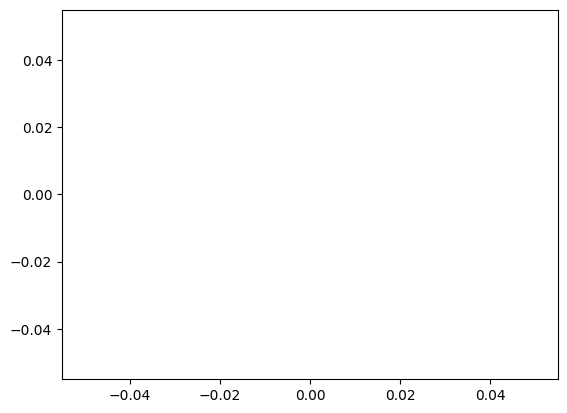

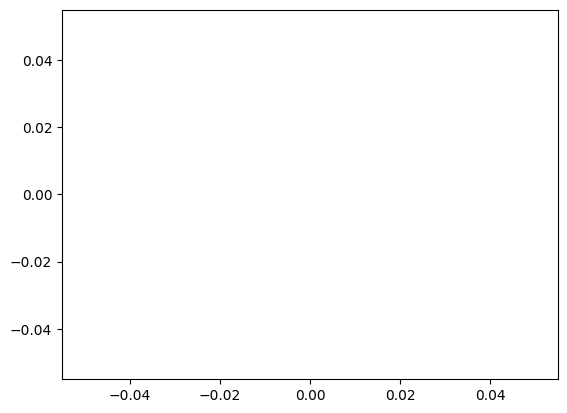

In [75]:
import traceback as tb

anm = CurveAnimation()

In [76]:
ITER_REPEATS = 100

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_iter = AnnData(split='train')
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        # tgt_input = tgt[:, :-1]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_one_out_mask(src, tgt)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        def step(i):
            nonlocal losses
            try:
                logits = model(src, tgt[:, :-1])
            except Exception as e:
                tb.print_exc()
                print(src.shape, tgt.shape)
                raise e
            # print(logits[0, 4])
            # logits = model(src, tgt[:, :])
            tokens = generate_tokens(logits)
    
            optimizer.zero_grad()
    
            # tgt_out = tgt[:, 1:]
            tgt_out = tgt[:, 1:]
            # print(decode_tokens(tgt_out))
            # print(decode_tokens(tokens))
    
            # print(tgt_out == PAD_IDX)
    
            hit_rate = ((tgt_out == tokens).sum() / count_words(tgt_out)).cpu().numpy()[()]
            # print()
            # sample_i = np.ra
            
            loss = loss_fn(logits.transpose(-1, -2), tgt_out)
            # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
            loss.backward()
    
            optimizer.step()
            losses += loss.item()
            
            # print('label', tgt_out)
            # print('pred', tokens)
            def tolist(x):
                return x.detach().cpu().numpy().tolist()
            def get_token_logits(logits, tokens):
                r = []
                for li, t in zip(logits, tokens):
                    r.append(f'{li[t]:.2f}')
                return r
            i = 0
            # anm.add_data(loss.item(), texts={
            #     'label': f'{tolist(tgt_out[i])}',
            #     'pred': f'{tolist(tokens[i])}',
            #     'logits': f'{get_token_logits(logits[i], tokens[i])}',
            # })
            anm.add_data(hit_rate, texts={
                'label': f'{tolist(tgt_out[i])}',
                'pred': f'{tolist(tokens[i])}',
                'logits': f'{get_token_logits(logits[i], tokens[i])}',
            })
            # anm.add_data(hit_rate, texts={'label': f'{tolist(tgt_out[i])}', 'pred': f'{tolist(tokens[i])}'})
        
        for i in range(ITER_REPEATS):
            step(i)

    # return losses / len(list(train_dataloader))
    return anm.curve_ma[-1]

In [77]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [78]:
# model = Transformer(embed_dim=128, src_vocab_size=src_vocab_size,
#                     target_vocab_size=target_vocab_size, seq_length=30,
#                     num_layers=16, expansion_factor=4, n_heads=16,
#                     target_mask_fn=target_one_out_mask)

# transformer = model
# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

# transformer = transformer.to(DEVICE)


## Model

In [79]:
MAX_LEN = 20

In [80]:
states_dir

'states/seq_ann_depth3_protbert_llm2vec/'

In [81]:
continue_previous = True
pickle_file = f'{states_dir}/seq_ann_transformer_llm2vec_embedding.pickle'
# continue_previous = False

In [82]:
#!pip install -U nn_pruning

In [83]:
class ProtBERT_Adapter(nn.Module):
    def __init__(self, config, embed_dim=1024):
        super(ProtBERT_Adapter, self).__init__()
        self.protbert_model = BertModel(config)
        assert(embed_dim <= 1024)
        self.embed_dim = embed_dim
        self.embed_idx = np.sort(np.random.choice(np.arange(1024), embed_dim, replace=False))
        print(self.embed_idx)

    def prune(self, p=0.25):
        print("Before pruning:")
        print(summary(self.protbert_model))
        
        pruner = TransformerPruner(self.protbert_model)
        
        ffn_mask = textpruner.pruners.utils.random_mask_tensor((16,4096), p=p)
        head_mask = textpruner.pruners.utils.random_mask_tensor((30,16), p=p, even_masks=False)
        
        print(ffn_mask, head_mask)
        
        pruner.prune(head_mask=head_mask, ffn_mask=ffn_mask,save_model=True)
        
        print("After pruning:")
        print(summary(self.protbert_model))

    def forward(self, input_ids, attention_mask=None):
        outputs = self.protbert_model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = outputs.last_hidden_state
        
        return embedding[:, :, self.embed_idx]

    def hidden_states(self, input_ids, attention_mask=None):
        outputs = self.protbert_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return {'': outputs.last_hidden_state[:, self.embed_idx]}


In [84]:
class StaticEncoder(nn.Module):
    pass

In [85]:

EMBED_DIM = 128

In [86]:
def sample_embed(embedding):
    sigma = embedding.std(0)
    rand_idx = np.random.choice(np.arange(embedding.shape[1]), EMBED_DIM, replace=False, p=sigma/sigma.sum())
    # print(sigma[rand_idx].shape)
    return embedding[:, rand_idx]
    
sampled_embedding = sample_embed(aligned_embedding)

In [87]:
from toy_transformer import Transformer

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)


loaded_from_pickle = False
if continue_previous and os.path.exists(pickle_file):
    print('Loading model')
    transformer = pickle.load(open(pickle_file, 'rb'))
    loaded_from_pickle = True
else:
    print('Creating new model')
    model = Transformer(embed_dim=EMBED_DIM, src_vocab_size=src_vocab_size,
                        target_vocab_size=target_vocab_size, source_seq_length=510+2, target_seq_length=MAX_LEN+2,
                        num_layers=5, expansion_factor=1, n_heads=32,
                        target_mask_fn=target_mask_fn,
                        target_embedding=torch.tensor(sampled_embedding, dtype=torch.float),
                        decoder_residue_links=True
                       )


    transformer = model
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    
    transformer = transformer.to(DEVICE)

Creating new model


## Substitue the encoder and tokenizer with ProtBERT

In [88]:
# USE_ProtBERT = False
USE_ProtBERT = True

In [89]:
from torch import nn

In [90]:
from transformers import BertConfig, BertModel, BertTokenizer
protbert_tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
protbert_config = BertConfig.from_pretrained('Rostlab/prot_bert')
# protbert_config = BertConfig.from_pretrained('states/protbert_pruned/')
protbert_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

In [91]:
tokenizers[SRC_LANGUAGE] = protbert_tokenizer

In [92]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(tokenizers[SRC_LANGUAGE](src_sample, return_tensors='pt')['input_ids'][0])
        tgt_batch.append(torch.tensor(tokenizers[TGT_LANGUAGE].encode(tgt_sample).ids))

    # pad_first_to_len(src_batch, seq_length)
    # pad_first_to_len(tgt_batch, seq_length)
    
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [93]:
import textpruner
from transformers import XLMRobertaForSequenceClassification,XLMRobertaTokenizer

from textpruner import summary, TransformerPruner
import sys


if not loaded_from_pickle and USE_ProtBERT:
    protbert_model = ProtBERT_Adapter(protbert_config, EMBED_DIM)
    protbert_model.protbert_model.load_state_dict(torch.load("states/prot_bert_weights.pth"))
    # protbert_model.protbert_model = pickle.load(open('states/prot_bert_pruned_25.pickle', 'rb'))
    # protbert_model.protbert_model.load_state_dict(torch.load("states/prot_bert_weights_pruned_25.pth"))
    protbert_model.prune()
    transformer.encoder = protbert_model


[  0   2  10  11  15  24  32  40  41  50  57  74  82  85  86  88  97 119
 135 138 141 151 171 179 183 188 191 192 203 214 224 226 233 237 241 251
 260 267 273 276 281 286 322 333 354 357 359 364 372 383 390 392 393 394
 408 411 419 424 428 429 441 457 463 470 477 480 484 499 503 508 528 539
 540 542 548 555 568 579 588 591 604 608 622 626 627 641 643 645 647 653
 656 657 680 685 693 705 716 730 740 750 754 757 760 761 772 773 774 775
 803 808 818 820 833 851 856 858 860 865 867 871 899 921 935 948 950 954
 956 963]
Before pruning:

LAYER NAME                  	        #PARAMS	     RATIO	 MEM(MB)
--model:                    	    419,931,136	   100.00%	 1601.91
  --embeddings:             	     40,994,816	     9.76%	  156.38
    --word_embeddings:      	         30,720	     0.01%	    0.12
    --position_embeddings:  	     40,960,000	     9.75%	  156.25
    --token_type_embeddings:	          2,048	     0.00%	    0.01
    --LayerNorm:            	          2,048	     0.00%	    0.01
  --enc

param_name = "protbert_model.encoder.layer.0.attention.self.query.weight"
initial_param = transformer.encoder.state_dict()[param_name].clone()

# Print initial parameter values
print(f"Initial parameter values for {param_name}:\n", initial_param)


updated_param = transformer.encoder.state_dict()[param_name]
print(f"Updated parameter values for {param_name}:\n", updated_param)


In [94]:

transformer = transformer.to(DEVICE)

In [95]:
sample_data = ann_dataset.sample(1)
sample_data

,seq,ann
383,M E T Y A V F G N P I A H S K S P F I H Q Q F ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...


In [96]:
sample_inputs = tokenizers[SRC_LANGUAGE](sample_data.iloc[0][SRC_LANGUAGE], return_tensors='pt')['input_ids'].to(DEVICE)
sample_inputs

tensor([[ 2, 21,  9, 15, 20,  6,  8, 19,  7, 17, 16, 11,  6, 22, 10, 12, 10, 16,
         19, 11, 22, 18, 18, 19,  6, 18, 18,  5, 17, 11,  9, 22, 16, 20,  7, 13,
          8,  5,  6, 16, 11, 17, 14, 19, 11, 17, 15,  5, 17,  6, 19, 19, 10,  6,
          7,  7, 12,  7,  6, 17,  8, 15,  8, 16, 19, 12,  9,  9,  6, 19,  6, 13,
          6, 14,  9,  5, 15,  9, 13,  6,  6,  5,  6,  7,  6,  8, 17, 15,  5, 21,
         13,  5,  9, 14,  7, 13,  5,  5,  7, 14, 17, 15, 14,  7,  8,  7,  5,  5,
         10, 14,  5,  9, 13,  5, 10, 19, 11, 13, 16,  7,  5, 13, 11,  5,  5, 11,
          7,  6,  7,  7,  6, 10, 13,  7,  8,  5,  5, 16,  5,  5, 10,  5, 14, 23,
          6,  8, 15, 11, 15, 17, 13, 15,  8, 10, 13,  6,  9,  9,  5,  6, 12,  5,
         19,  6, 22, 15,  7, 10, 11, 18,  6,  5, 10, 21, 14,  9,  5,  9,  7, 22,
          9, 19, 14,  5, 11, 11, 17,  6, 15, 10, 10,  7, 11, 10,  7, 14, 11, 16,
          6, 11, 16, 10, 10,  5, 11, 22, 16,  7, 11, 20, 23, 20, 14, 21, 19, 20,
         18, 12,  7, 12, 15,

In [97]:
sample_target = torch.tensor([tokenizers[TGT_LANGUAGE].encode(sample_data.iloc[0][TGT_LANGUAGE]).ids]).to(DEVICE)
sample_target

tensor([[ 2,  5,  6,  8, 12, 14,  7, 11,  3]], device='cuda:0')

In [98]:
# outputs = transformer.hidden_states(sample_inputs, sample_target)
# outputs.keys()

In [99]:
print(str(transformer).replace('  ', '|   '))

Transformer(
|   (encoder): ProtBERT_Adapter(
|   |   (protbert_model): BertModel(
|   |   |   (embeddings): BertEmbeddings(
|   |   |   |   (word_embeddings): Embedding(30, 1024, padding_idx=0)
|   |   |   |   (position_embeddings): Embedding(40000, 1024)
|   |   |   |   (token_type_embeddings): Embedding(2, 1024)
|   |   |   |   (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
|   |   |   |   (dropout): Dropout(p=0.0, inplace=False)
|   |   |   )
|   |   |   (encoder): BertEncoder(
|   |   |   |   (layer): ModuleList(
|   |   |   |   |   (0-1): 2 x BertLayer(
|   |   |   |   |   |   (attention): BertAttention(
|   |   |   |   |   |   |   (self): BertSelfAttention(
|   |   |   |   |   |   |   |   (query): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |   |   |   (key): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |   |   |   (value): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |  

In [100]:
x = {}
y = x[2] = 3
y

3

In [101]:
def substitute_encoder(model, encoder):
    model.encoder = encoder
    # need to make sure the embedding dimensions are the same

## Check Mem usage

In [102]:
# from torch.profiler import profile, record_function, ProfilerActivity

# # Use profiler to track memory usage
# with profile(activities=[ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
#     with record_function("model_inference"):
#         for i in range(10):
#         # i = 2
#             inputs = tokenizers['seq'](ann_dataset.iloc[i]['seq'], return_tensors='pt')['input_ids'].to(DEVICE)
#             target = torch.tensor([tokenizers['ann'].encode(ann_dataset.iloc[i]['ann']).ids]).to(DEVICE)
#             outputs = transformer(inputs, target)

# # Print profiling results
# print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

In [103]:
# len(ann_dataset.iloc[i]['seq'])

In [104]:
# protbert_model.protbert_model(**protbert_tokenizer(ann_dataset.iloc[2]['seq'], return_tensors='pt').to(DEVICE))

## Training

In [105]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0000005, betas=(0.95, 0.999), eps=1e-9)

In [106]:
BATCH_SIZE = 5
ITER_REPEATS = 1

In [107]:

# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)


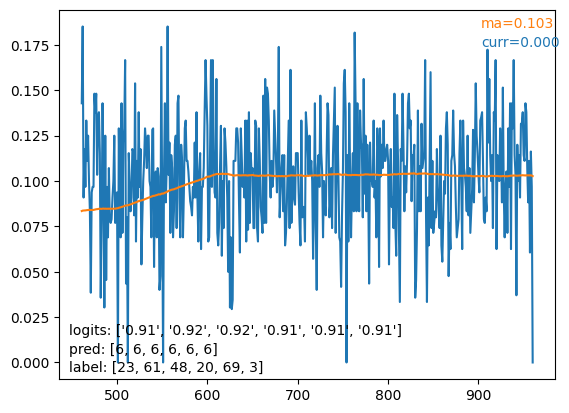

KeyboardInterrupt: 

In [108]:
NUM_EPOCHS = 1

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    eval_res = evaluate(transformer)
    val_loss = eval_res['loss']
    val_hit  = eval_res['hit_rate']
    # if epoch % 10 == 0:

print(( f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    

In [ ]:
torch.nn.rei
transformer.

## Debugging

In [109]:
sample_data = ann_dataset.sample(1)
sample_data

,seq,ann
10471,M S R S G T A G Y D M S I I F S P Q G K L Y Q ...,GO:0008150 GO:0008152 GO:0044238 GO:0009056 GO...


In [110]:
sample_inputs = tokenizers[SRC_LANGUAGE](sample_data.iloc[0][SRC_LANGUAGE], return_tensors='pt')['input_ids'].to(DEVICE)
sample_inputs

tensor([[ 2, 21, 10, 13, 10,  7, 15,  6,  7, 20, 14, 21, 10, 11, 11, 19, 10, 16,
         18,  7, 12,  5, 20, 18, 11,  9, 20,  6, 19, 12,  6, 11, 12, 15,  7,  7,
          5, 15, 10,  8,  7, 11, 13,  7, 12, 14, 23,  8,  8,  8,  6, 15, 18, 12,
         12, 11, 16, 14, 12,  5, 11, 14, 16, 12, 10,  8, 15, 10,  5, 20, 12,  5,
         15, 14, 20, 11,  7, 23,  8, 18, 15,  7, 11,  8, 16, 14, 10, 12, 10, 18,
          6, 10, 13,  6, 11, 18,  9, 23,  6, 15, 19, 22, 22, 12, 19,  7, 20, 18,
         11, 16, 16, 17,  8,  5,  6, 12, 13, 21,  6, 14, 11,  6, 18,  5, 10, 15,
         18, 22,  6, 10,  6, 13, 16,  5,  7,  8,  6, 21, 11,  5, 11,  7, 11, 14,
         14,  9,  5,  7, 16, 18,  5, 19, 12,  8, 14, 16,  6,  7,  8, 19, 15,  7,
         20, 12,  6, 15,  6,  6,  7,  9, 12,  9, 18,  9, 10, 15, 17, 19,  5,  9,
         12, 12, 19, 12, 10, 17, 16, 18,  5, 10, 12, 14,  9, 15, 11, 18,  8, 10,
          5, 11,  8, 21,  6, 11, 10, 15,  5, 18, 10,  8,  5,  7,  6, 14,  5, 12,
         10, 10, 14,  5,  9,

In [111]:
sample_target = torch.tensor([tokenizers[TGT_LANGUAGE].encode(sample_data.iloc[0][TGT_LANGUAGE]).ids]).to(DEVICE)
sample_target

tensor([[ 2,  5,  8, 12, 19,  7,  3]], device='cuda:0')

In [112]:
transformer.encoder(sample_inputs).shape

torch.Size([1, 252, 128])

In [113]:
outputs = transformer(sample_inputs, sample_target)
outputs

tensor([[[4.6304e-04, 1.0384e-04, 1.7124e-04, 1.3730e-04, 2.1670e-03,
          2.6050e-04, 9.2121e-01, 6.8794e-04, 3.3958e-04, 1.4696e-04,
          3.4400e-04, 3.4742e-04, 2.0464e-04, 1.6986e-04, 1.6964e-04,
          4.4861e-04, 1.3087e-04, 1.6264e-04, 5.1994e-04, 7.2182e-04,
          4.5418e-04, 3.9014e-04, 2.0881e-04, 1.0567e-03, 9.0612e-05,
          7.4666e-05, 1.8457e-04, 9.7812e-04, 4.6843e-04, 4.0874e-04,
          2.1938e-04, 2.1146e-04, 3.5136e-04, 1.0568e-04, 5.7544e-05,
          4.5717e-04, 1.7765e-04, 5.5149e-04, 9.7193e-04, 8.9509e-04,
          1.8351e-03, 1.8839e-04, 8.7140e-04, 4.7354e-04, 7.1803e-04,
          9.2548e-05, 2.6845e-05, 8.5035e-04, 8.7239e-04, 2.2987e-05,
          8.8648e-05, 5.1625e-03, 8.4610e-05, 3.1900e-04, 3.3582e-04,
          1.2109e-03, 1.1252e-04, 2.4376e-04, 1.1163e-03, 6.0205e-04,
          1.8176e-03, 1.3498e-03, 2.7487e-04, 5.8847e-04, 8.7477e-05,
          8.4778e-04, 5.2264e-04, 1.9907e-04, 4.2594e-03, 4.7366e-04,
          2.9140e-04

In [114]:
hidden_states = transformer.hidden_states(sample_inputs, sample_target)

RuntimeError: shape '[1, 128, 32, 4]' is invalid for input of size 131072

In [ ]:
hidden_states.keys()

In [ ]:
list(transformer.decoder.fc_out.named_parameters())[0][1]

In [ ]:
hidden_states['decoder.fc_out'][0, 1, :]

In [ ]:
for k, v in hidden_states.items():
    print(k, v.shape)

In [ ]:
transformer.decoder.embedding_layer(sample_target[0, 3:4])

In [ ]:
list(transformer.decoder.embedding_layer)

## Evaluate

In [ ]:
evaluate(transformer)

In [ ]:
plt.plot(anm.curve_y)

In [ ]:
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:
pickle_file

In [ ]:
torch.cuda.empty_cache()